In [17]:
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt

data = pd.read_csv("data/challenger_data.csv")
data

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,6/27/82,80,NaN
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1


In [14]:
challenger_data = data.drop(index=24, axis=0).dropna()
challenger_data["Temperature"] = challenger_data["Temperature"].astype(int)
challenger_data["Damage Incident"] = challenger_data["Damage Incident"].astype(int)
print(challenger_data.info())
challenger_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 0 to 23
Data columns (total 3 columns):
Date               23 non-null object
Temperature        23 non-null int32
Damage Incident    23 non-null int32
dtypes: int32(2), object(1)
memory usage: 552.0+ bytes
None


,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1
10,04/06/1984,63,1


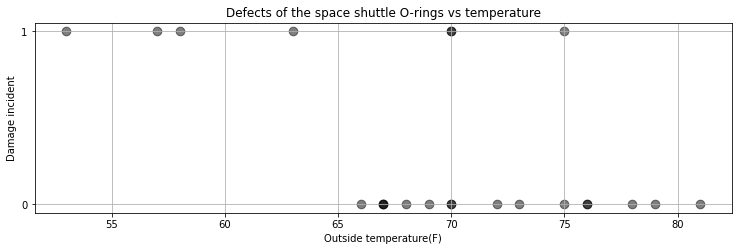

In [16]:
plt.figure(figsize=(12.5, 3.5))
plt.scatter(challenger_data["Temperature"], challenger_data["Damage Incident"], 
            s=75, color="k", alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage incident")
plt.xlabel("Outside temperature(F)")
plt.title("Defects of the space shuttle O-rings vs temperature")
plt.grid()

### 失效概率建模  $$P=\frac{1}{ 1 + e^{\beta t + \alpha }}$$

In [81]:
def logistic(t, beta, alpha):
    return 1. / (1. + np.exp(beta * t + alpha))

In [82]:
temperature = challenger_data["Temperature"].values
label = challenger_data["Damage Incident"].values

beta = pm.Normal("beta", 0, 0.001, value=0)
alpha = pm.Normal("alpha", 0, 0.001, value=0)
p = pm.Lambda("p", lambda alpha=alpha, beta=beta, t=temperature: logistic(t, beta, alpha))
observations = pm.Bernoulli("obs", p, value=label, observed=True)

C:\ProgramData\Anaconda3\lib\site-packages\pymc\MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


C:\ProgramData\Anaconda3\lib\site-packages\pymc\MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 120000 of 120000 complete in 7.8 secPlotting beta
Plotting alpha


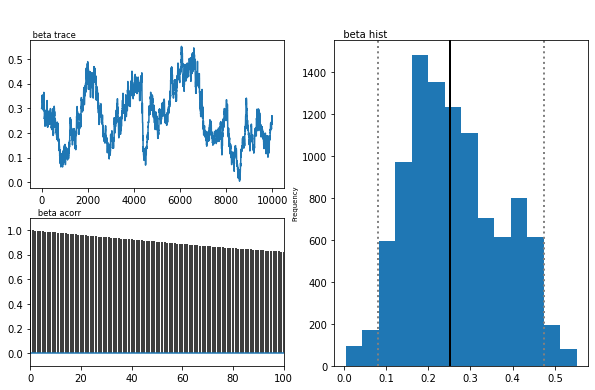

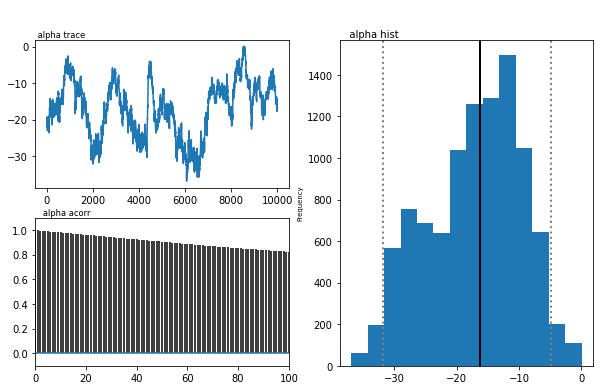

In [125]:
model = pm.Model([observations, beta, alpha, p])
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(120000, 100000, 2)
import pymc.Matplot as mcplot
mcplot.plot(mcmc)

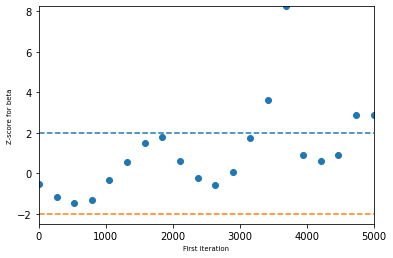

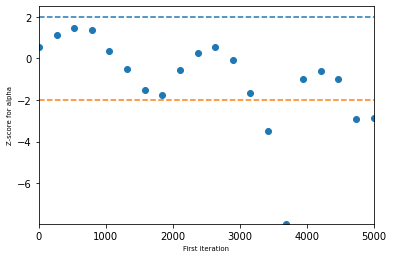

In [126]:
scores = pm.geweke(mcmc, intervals=20)
mcplot.geweke_plot(scores)

In [84]:
beta_samples = mcmc.trace("beta")[:]
alpha_samples = mcmc.trace("alpha")[:]

Text(0.05, 0.5, 'Density')

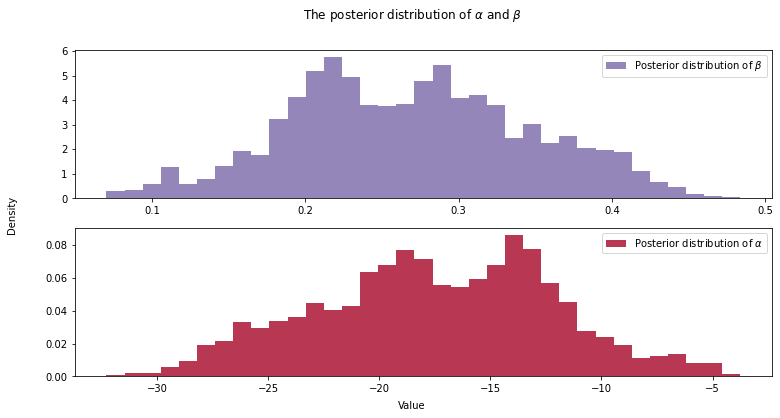

In [85]:
fig, axes = plt.subplots(figsize=(12.5, 6), nrows=2)
colors = ["#7A68A6", "#A60628"]

for i, variable in enumerate(["beta", "alpha"]):
    ax = axes[i]
    ax.hist(mcmc.trace(variable)[:], histtype="stepfilled", bins=35, alpha=0.8, density=True, 
            color=colors[i], label=f"Posterior distribution of $\\{variable}$")
    ax.legend()
fig.suptitle(r"The posterior distribution of $\alpha$ and $\beta$")
fig.text(0.5, 0.05, "Value", ha="center")
fig.text(0.05, 0.5, "Density", va="center", rotation="vertical")

所有的$\beta$都大于0，意味着温度确实对事故有影响，同理有理由相信$\alpha$基本都为负数且与0较远。  

In [89]:
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)
p_t = logistic(t.reshape(-1, 1), beta_samples, alpha_samples)  # (50, 20000)
mean_p_t = p_t.mean(axis=1)  # (50, )

平均概率与温度的关系

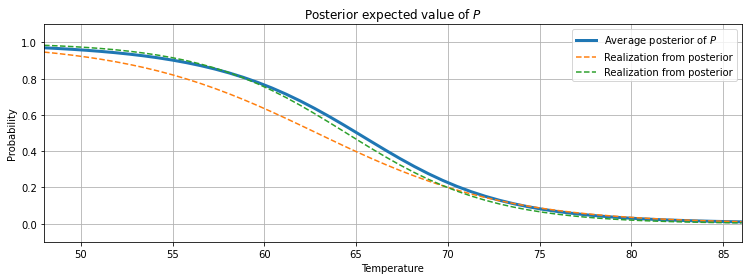

In [93]:
plt.figure(figsize=(12.5, 4))
plt.plot(t, mean_p_t, lw=3, label="Average posterior of $P$")
plt.plot(t, p_t[:, 0], ls="--", label="Realization from posterior")
plt.plot(t, p_t[:, -2], ls="--", label="Realization from posterior")
plt.title("Posterior expected value of $P$")
plt.legend()
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("Probability")
plt.xlabel("Temperature")
plt.grid()

95% 置信区间

In [105]:
low, high = np.quantile(p_t, [0.025, 0.975], axis=1)

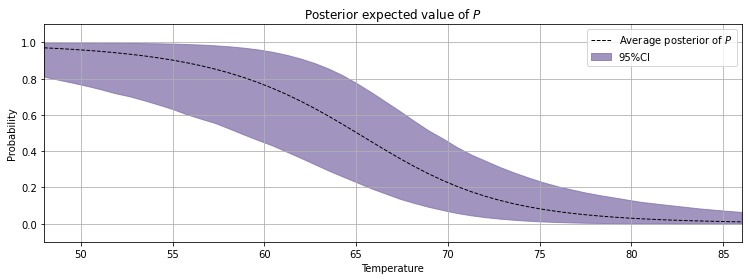

In [107]:
plt.figure(figsize=(12.5, 4))
plt.fill_between(t, low, high, alpha=0.7, color="#7A68A6", label="95%CI")
plt.plot(t, mean_p_t, ls="--", lw=1, color="k", label="Average posterior of $P$")
plt.title("Posterior expected value of $P$")
plt.legend()
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("Probability")
plt.xlabel("Temperature")
plt.grid()

>在60-70度间分布较宽，需要我们在此区间进行更多的实验

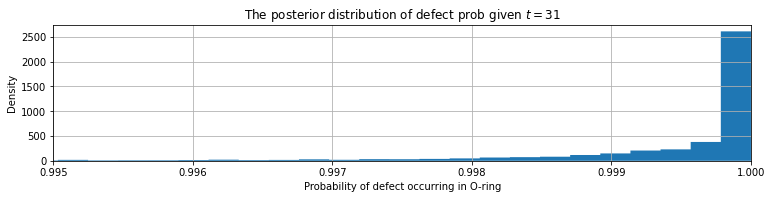

In [112]:
# 挑战者号发射当天
t = 31
p = logistic(t, beta_samples, alpha_samples)  # (20000,)
plt.figure(figsize=(12.5, 2.5))
plt.xlim(0.995, 1)
plt.hist(p, bins=1000, density=True, histtype="stepfilled")
plt.title(f"The posterior distribution of defect prob given $t={t}$")
plt.ylabel("Density")
plt.xlabel("Probability of defect occurring in O-ring")
plt.grid()